## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks
# Question 1: A simple classifier, 20 marks (70%)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
# To define a neural network in PyTorch, we create a class that inherits from nn.Module. 
# We define the layers of the network in the init function and specify how data will pass through the network in the forward function. 
# To accelerate operations in the neural network, we move it to the GPU if available.
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# In a single training loop, the model makes predictions on the training dataset (fed to it in batches),
# and backpropagates the prediction error to adjust the model’s parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
# Create data loaders.
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Q1.1 (1 point)
Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.   

Size/shape of images is (1, 28, 28)


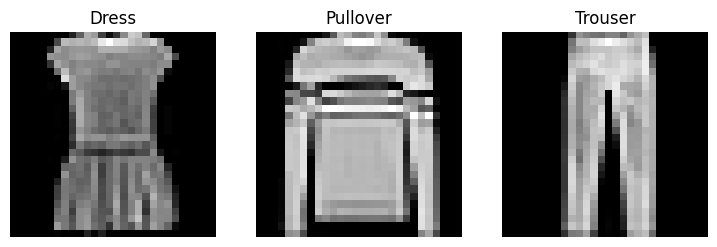

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

clothing_type = [1,2,3]
img = []
label = []

for i in range(len(training_data)):
    training_image, training_label = training_data[i]
    if training_label in clothing_type:
        clothing_type.remove(training_label)
        img.append(training_image)
        label.append(training_label)

print(f"Size/shape of images is {tuple(img[0].shape)}")

plt.figure(figsize = (9, 3))
for i in range(len(img)):
    plt.subplot(1, 3, i+1)
    plt.imshow(img[i][0,:,:], cmap = 'gray')
    plt.title(class_names[label[i]])
    plt.axis('off')
plt.show()


Q1.2 (2 point) Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |24.3%      |
|0.1|87.44%          |
|0.01|82.99%         |
|0.001  |71.1%        |


In [11]:
learning_rate = [1, 0.1, 0.01, 0.001]
epochs = 10

accuracy = {}
loss_data = {}
for lr in learning_rate:
    loss_data[lr] = []

for lr in learning_rate:
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for t in range(epochs):
        #print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_accuracy  = test(test_dataloader, model, loss_fn)
        loss_data[lr].append(test_loss)
    
    accuracy[lr] = test_accuracy


Learning rate : 1, Accuracy : 24.3%
Learning rate : 0.1, Accuracy : 87.44%
Learning rate : 0.01, Accuracy : 82.99%
Learning rate : 0.001, Accuracy : 71.1%


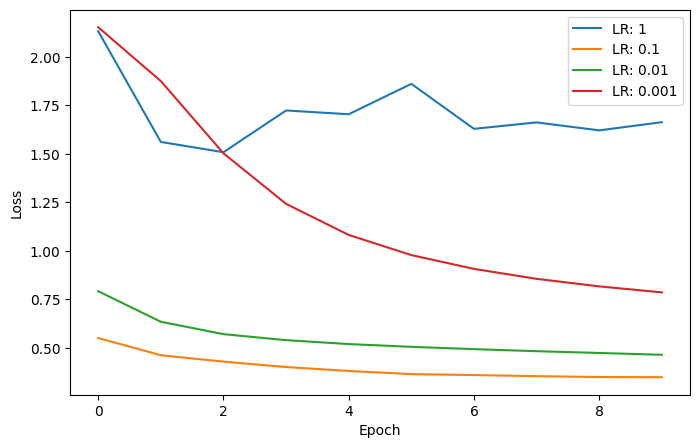

In [12]:
for lr in learning_rate:
    print(f"Learning rate : {lr}, Accuracy : {accuracy[lr]}%")

plt.figure(figsize=(8, 5))
for lr in learning_rate:
    plt.plot(loss_data[lr], label = f"LR: {lr}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Q1.3 (3 point) Report the number of epochs when the network converges (or nukber of epochs for the best accuracy, if it fails to converge). Fill in the table below and plot the loss curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1|11.06      |4     |
|0.1|87.97          |10    |
|0.01|83.51         |10    |
|0.001|70.85        |10     |


In [13]:
learning_rate = [1, 0.1, 0.01, 0.001]
epochs = 10

# Initialize a dictionary to hold the loss history for each learning rat
loss_data = {}
best_epoch = {}
best_accuracy = {}
for lr in learning_rate:
    loss_data[lr] = []
    best_accuracy[lr] = 0
    best_epoch[lr] = 0

for lr in learning_rate:
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for t in range(epochs):
        #print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
        loss_data[lr].append(test_loss)

        if test_accuracy > best_accuracy[lr]:
            best_accuracy[lr] = test_accuracy
            best_epoch[lr] = t + 1

Learning rate: 1, Best Accuracy: 11.06%, Best Epoch: 4
Learning rate: 0.1, Best Accuracy: 87.97%, Best Epoch: 10
Learning rate: 0.01, Best Accuracy: 83.50999999999999%, Best Epoch: 10
Learning rate: 0.001, Best Accuracy: 70.85000000000001%, Best Epoch: 10


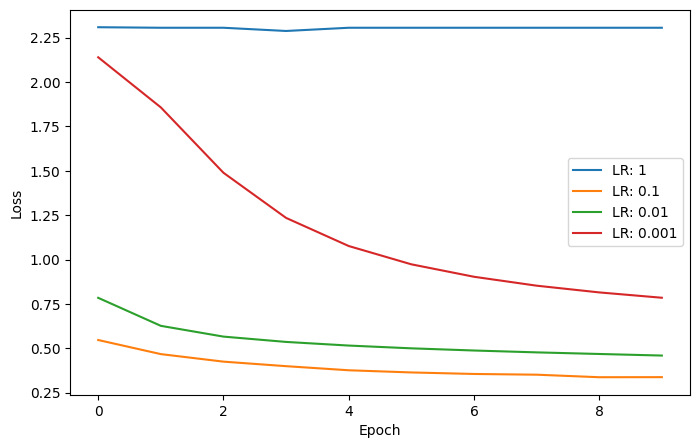

In [14]:
# Print the best accuracy and corresponding epoch for each learning rate
for lr in learning_rate:
    print(f"Learning rate: {lr}, Best Accuracy: {best_accuracy[lr]}%, Best Epoch: {best_epoch[lr]}")

plt.figure(figsize=(8, 5))
for lr in learning_rate:
    plt.plot(loss_data[lr], label = f"LR: {lr}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Q1.4 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

In both table 1 and table 2, with a learning rate of 1, we see that the accuracy is lower than the other learning rates in both. This is very likely due to overshooting during gradient descent. To support this, in table 2, we see that the best epoch number was 4, which means that the model has probably already overshot the optimal solution.

The lower learning rates (0.1, 0.01 and 0.001) had much higher accuracies. This would be because of the smaller update to weights, meaning more precise approach to optimal solution. The 0.01 and 0.001 learning rates converged slower than the 0.1, but would probably result in a more accurate result. With a limited epoch number of 10, we need to find a learning rate to train the model the best. If we had unlimited epochs, the lowest learning rate would be the best as it would not overshoot as much (but could get stuck in local minimums). But since we dont, we need to find a higher learning rate to find the solution quicker. In this scenario, the best balance was a learning rate of 0.1.

Q1.5 (5 points) Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |87.43%      |669706|
|Deeper|87.49%          |932362|
|Wider|87.28%         |1863690|


In [15]:
# Wider network
class WiderNeuralNetwork(nn.Module):
    def __init__(self):
        super(WiderNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024), # double neurons
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

# Deeper network
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512), # extra layer
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

def param_num(model_name):
    total = 0
    for param in model_name.parameters():
        if param.requires_grad:
            total += param.numel()
    return total

base_model = NeuralNetwork().to(device)
print(f'Trainable parameters in base model: {param_num(base_model)}')

wider_model = WiderNeuralNetwork().to(device)
print(f'Trainable parameters in wider model: {param_num(wider_model)}')

deeper_model = DeeperNeuralNetwork().to(device)
print(f'Ttrainable parameters in deeper model: {param_num(deeper_model)}')

epochs = 10
models = [base_model, wider_model, deeper_model]
model_names = ["BaseModel", "WiderModel", "DeeperModel"]

loss_data = {}
for name in model_names:
    loss_data[name] = []

for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
        loss_data[model_name].append(test_loss)
    print(f"Final accuracy for {model_name}: {test_accuracy}%")


Trainable parameters in base model: 669706
Trainable parameters in wider model: 1863690
Ttrainable parameters in deeper model: 932362
Final accuracy for BaseModel: 87.42999999999999%
Final accuracy for WiderModel: 87.49%
Final accuracy for DeeperModel: 87.28%


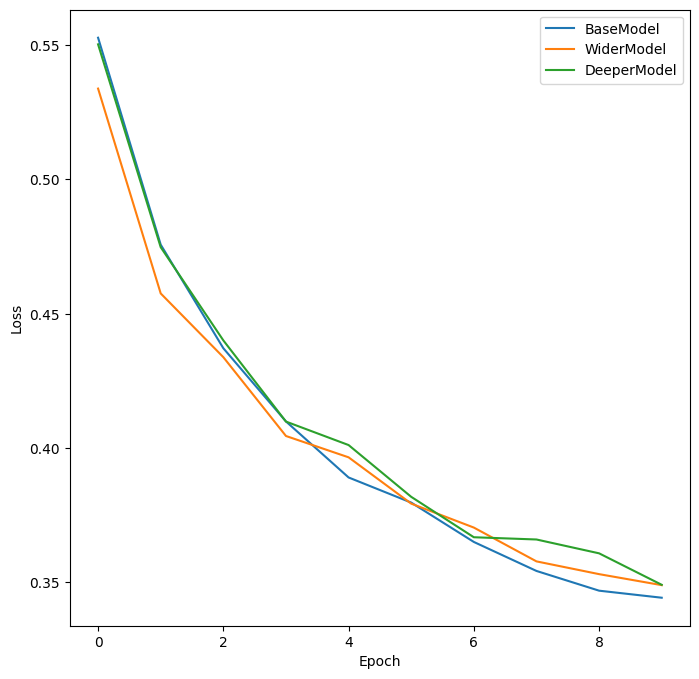

In [16]:
plt.figure(figsize=(8, 8))
for name in model_names:
    plt.plot(loss_data[name], label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

As we look at the data for the three different networks, we can see that the trainable parameters is the lowest for the base model, approx 3x the base for the wider model and approx 1.5x larger the base for the deeper model. Obviously this would change if the networks were deeper or wider, but this is only interesting when looking at it in terms of the trainable parameters versus the final accuracy. We can see that there were diminishing returns with the trainable parameters vs the final accuracy, as the final accuracy between all the models was within 1% of eachother. We see here that adding more parameters to a neural network does not guarantee improved model performance.

Q1.6 (2 points) Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

In [17]:
class Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1, bias=False) 
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=False)
        self.linear = nn.Linear(32*7*7, 10, bias=False)
        
    def set_grad(self, var):
        def hook(grad):
            var.grad = grad
        return hook
    
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = F.max_pool2d(x1, 2)
        
        x2 = F.relu(self.conv2(x1))
        x2 = F.max_pool2d(x2, 2)
        
        x3 = self.linear(x2.view(x2.size(0), -1))
        
        return x3


model = Simple()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model.train()
mean_grads = []
steps = 0
for epoch in range(10):
    if steps >= 100:
        break
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        output = model(images)
        loss = criterion(output, targets)
        loss.backward()
        
        total_grads = 0.0
        total_params = 0

        for p in model.parameters():
            if p.requires_grad and p.grad is not None:
                p.register_hook(model.set_grad(p))
                total_grads += p.grad.abs().mean()
                total_params += 1
        if total_params > 0:
            mean_grad = total_grads / total_params
        else:
            mean_grad = 0.0
        mean_grads.append(mean_grad.item())
        optimizer.step()
        steps += 1
        if steps >= 100:
            break

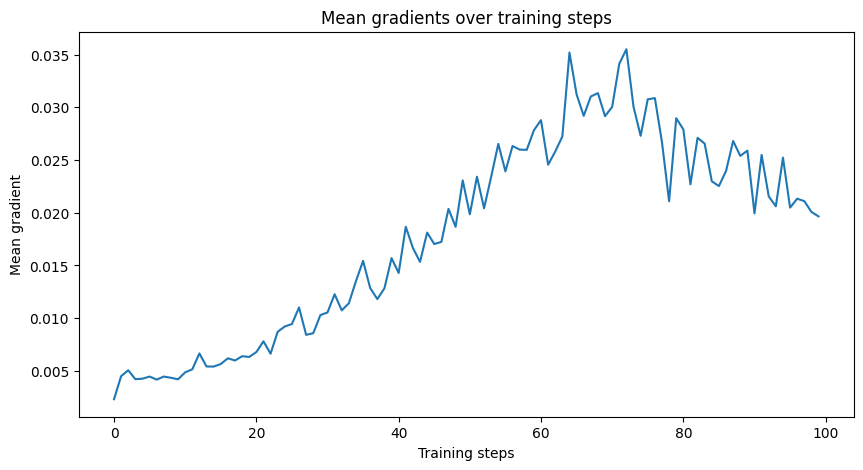

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(mean_grads)
plt.title('Mean gradients over training steps')
plt.xlabel('Training steps')
plt.ylabel('Mean gradient')
plt.show()

My observations with this graph is that throughout the entire graph, the mean gradient oscillates. This would be because of the randomness of the SGD. The general trend however, is that the mean of the gradients increase up to approximately 70 training steps to a local maxima, then gradually decrease.The graph of mean gradient vs training steps should decrease because when the model is being trained, the model should optimise and tent towards an optimal solution, so the gradients should get smaller. The gradient should become smallest when the parameters approach values that minimize the loss function.